In [ ]:
# !git clone https://github.com/dmc27/missing_pixels.git

In [1]:
import cv2 as cv
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.metrics import accuracy_score

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR


from utils.utils import *
from utils.database import MissingPixelDataset
from model.architecture import *


import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)



BLOCK_SIZE = 8
BATCH_SIZE = 2048
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5
# WEIGHT_DECAY = 0.05
STEPLR_GAMMA = 0.1
RUN_UTILITY = False


IMG_PATH = './dataset/original_image/'
IMG_TRAINING_PATH = './dataset/training_image/train/'
IMG_SAVE_PATH = './dataset/missing_pixel/'

In [2]:
if RUN_UTILITY:
    create_dataset_autoencoder(IMG_PATH, IMG_SAVE_PATH, BLOCK_SIZE, img_size=(256, 256))

In [3]:
# Calling PrepareDataset class in the utilities for preparing the dataset for training,
# X is the input to the network architecture, and y is the target output of the network
data = PrepareDataset(IMG_TRAINING_PATH, IMG_SAVE_PATH, block_size=8)
X, y = data.create_dataset_2d(sample_size = 30000)


# Creating dataset for the pytorch model (converted to tensor)
train_dataset = MissingPixelDataset(X, y, scaling=False)


# Create training dataloader to make a batch learning for the pytorch model
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

100%|██████████| 30000/30000 [00:26<00:00, 1151.57it/s]


In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
model = ConvModel2().double().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=STEPLR_GAMMA)

In [6]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (X_train, y_train) in enumerate(pbar):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        output = model(X_train.unsqueeze(1))
        
        loss = criterion(output, y_train)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        pbar.set_description(desc= f'Epoch {epoch} loss={loss.item()} batch_id={batch_idx}')
    
    train_loss /= len(train_loader.dataset)

    print('Train set: Average loss: {:.32f}'.format(train_loss))

In [ ]:
def test

In [7]:
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, device, train_dataloader, optimizer, criterion, epoch)
    # plot_loss()
    # test(model, device, test_dataloader, criterion)
    # scheduler.step()

Epoch 1 loss=0.004205699762609184 batch_id=131:   1%|          | 132/15000 [00:19<37:00,  6.69it/s] 


KeyboardInterrupt: 

(256, 256)

In [9]:
torch.save(model.state_dict(), 'trained_model/convmodel2_30k_1.pth')

In [10]:
test_image_name = 'balloon.bmp'

In [ ]:
model.eval()
image = data._preprocess_image('./dataset/original_image/balloon.bmp')
tiled_image = data._reshape_split(image)
X = tiled_image.copy()
X[:, 3:5, 3:5] = np.array([[None, None],
                            [None, None]])
test = X[~np.isnan(X)].reshape(-1, 60) / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X[:, 3:5, 3:5] = prediction_result
X = X.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
# a = model(torch.tensor(X[:1024], dtype=torch.float32).to(device)).detach().cpu().numpy()

In [11]:
model.eval()
image = data._preprocess_image('./dataset/original_image/' + test_image_name)
tiled_image = data._reshape_split(image)
X = tiled_image.copy()
X[:, 3:5, 3:5] = np.array([[0., 0.],
                            [0., 0.]])
test = X / 255.
prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
X[:, 3:5, 3:5] = prediction_result
X = X.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)

In [12]:
# # DO THE TRAINING
# # BATCH_SIZE = 4
# checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
#   save_best_only=True)
# callbacks_list = [checkpoint]

# # fit the model
# history = model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
#   validation_split=0.1, callbacks=callbacks_list)
# # history = model.fit(X_trn, y_trn, epochs=200, batch_size=1,
# #   validation_split=0.1, callbacks=callbacks_list)

In [13]:
# pred = data.test_model(model=model)

In [14]:
# fig = plt.figure(figsize=(8, 10))
# plt.subplot(3,1,1)
# plt.plot(history.history['mse'])
# plt.plot(history.history['mse'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['trn', 'val'], loc='lower right')

# plt.subplot(3,1,2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['trn', 'val'], loc='upper right')
# plt.tight_layout()

# plt.subplot(3,1,3)
# plt.semilogy(history.history['loss'])
# plt.semilogy(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['trn', 'val'], loc='upper right')
# plt.tight_layout()


MSE = 1578.83


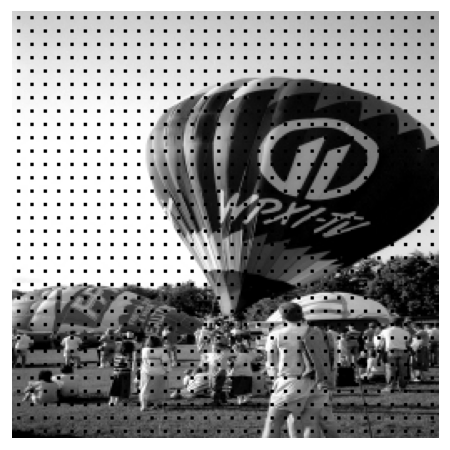

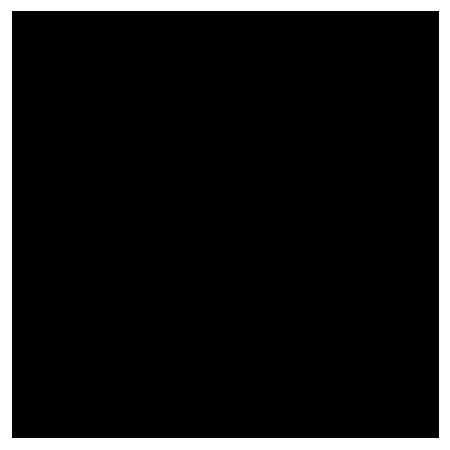

In [15]:
img = cv.imread(join(IMG_PATH, test_image_name), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

# compute the MSE between the original and reconstructed images
err = X - img
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(X, "gray", dpi=72)
imshow(X - img, 'gray', dpi = 72)
